Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 52.6MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.72MB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 14.6MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.00MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Epoch 1, Loss: 0.1829
Epoch 2, Loss: 0.0522
Epoch 3, Loss: 0.0372
Surrogate Model Accuracy: 60.75%


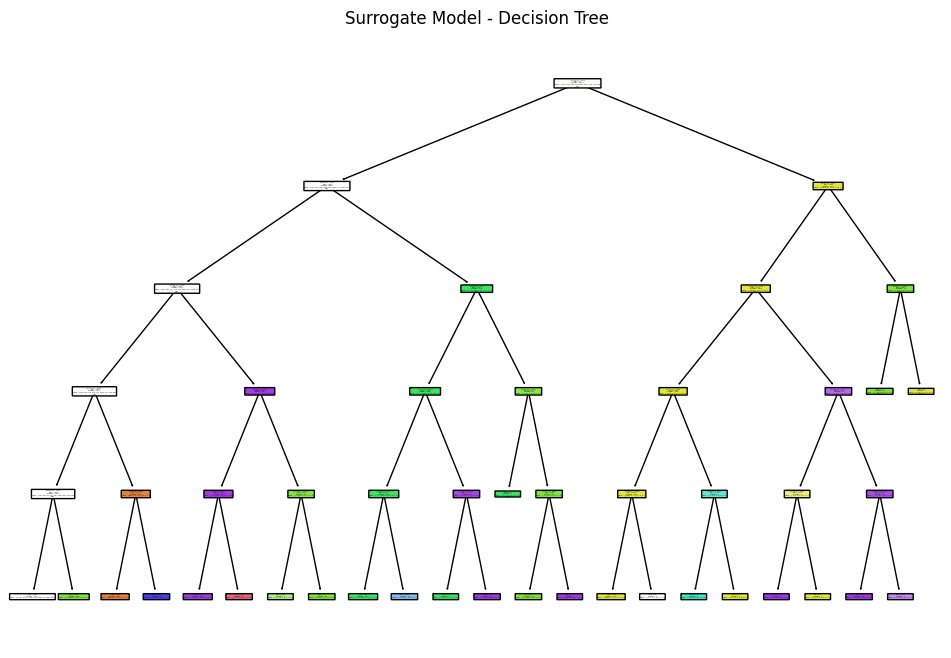

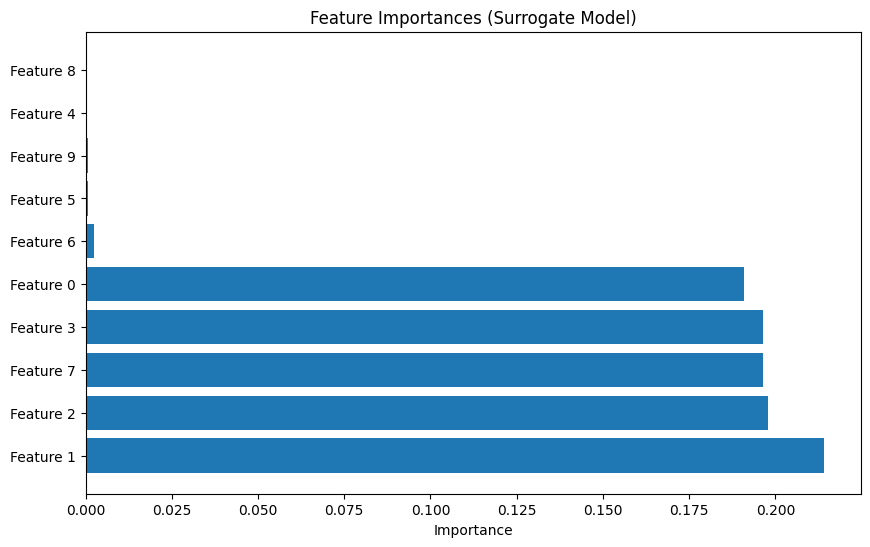

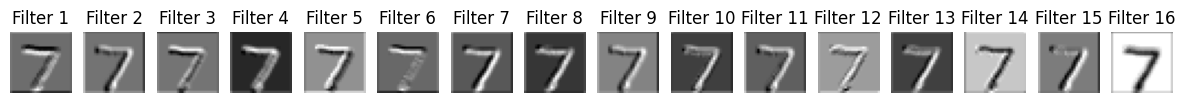

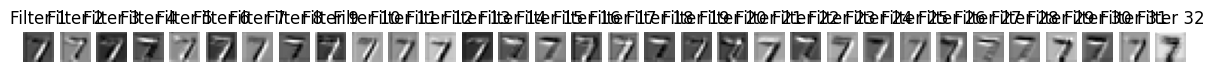

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

# 1. Load the Dataset (MNIST)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

# 2. Define a Simple CNN Model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 32 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize the Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 3. Train the CNN Model
def train(model, trainloader, criterion, optimizer, epochs=3):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)  # CNN outputs (logits)

            # Print CNN output (logits) for the first image in the batch
            #print(f"Logits for first image in batch: {outputs[0]}")  # First image in the batch

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch + 1}, Loss: {running_loss / len(trainloader):.4f}")

train(model, trainloader, criterion, optimizer)

# 4. Extract Features for Surrogate Model
def extract_features(model, dataloader):
    model.eval()
    features, labels = [], []
    with torch.no_grad():
        for images, lbls in dataloader:
            images = images.to(device)
            outputs = model(images)  # CNN outputs (logits)

            # Print CNN outputs (logits) for the first image in each batch
            #print(f"Logits for first image in batch: {outputs[0]}")  # This will print the logits for the first image

            features.extend(outputs.cpu().numpy())  # Extract CNN outputs as features
            labels.extend(lbls.numpy())
    return np.array(features), np.array(labels)

X_train, y_train = extract_features(model, trainloader)
X_test, y_test = extract_features(model, testloader)

# 5. Train a Decision Tree Surrogate Model
dt = DecisionTreeClassifier(max_depth=5)  # Decision Tree model
dt.fit(X_train, y_train)

# Evaluate Surrogate Model
acc = dt.score(X_test, y_test)
print(f"Surrogate Model Accuracy: {acc * 100:.2f}%")

# 6. Visualize the Decision Tree (Surrogate Model)
def visualize_surrogate_model(dt):
    plt.figure(figsize=(12, 8))
    plot_tree(dt, filled=True, feature_names=[f"Feature {i}" for i in range(X_train.shape[1])], class_names=[str(i) for i in range(10)], rounded=True)
    plt.title("Surrogate Model - Decision Tree")
    plt.show()

visualize_surrogate_model(dt)

# 7. Visualize Feature Importance of the Surrogate Model
def plot_feature_importance(dt, feature_names):
    feature_importances = dt.feature_importances_
    indices = np.argsort(feature_importances)[::-1]

    plt.figure(figsize=(10, 6))
    plt.title("Feature Importances (Surrogate Model)")
    plt.barh(range(X_train.shape[1]), feature_importances[indices], align="center")
    plt.yticks(range(X_train.shape[1]), [f"Feature {i}" for i in indices])
    plt.xlabel("Importance")
    plt.show()

# Visualizing Feature Importance of the Surrogate Model
plot_feature_importance(dt, [f"Feature {i}" for i in range(X_train.shape[1])])


# --- Visualizing Feature Maps from the CNN --- #
def visualize_feature_maps(model, input_image):
    model.eval()
    layers = [model.conv1, model.conv2]  # Choose the convolutional layers to visualize
    activations = []

    def save_activation(name):
        def hook(model, input, output):
            activations.append(output)
        return hook

    # Register hooks to the convolutional layers
    hooks = []
    for layer in layers:
        hooks.append(layer.register_forward_hook(save_activation(layer.__class__.__name__)))

    # Perform a forward pass
    input_image = input_image.unsqueeze(0).to(device)
    model(input_image)

    # Visualize the feature maps
    for i, activation in enumerate(activations):
        activation = activation.squeeze(0).cpu().detach().numpy()
        num_filters = activation.shape[0]

        # Display the feature maps for each filter
        fig, axes = plt.subplots(1, num_filters, figsize=(15, 8))
        for j in range(num_filters):
            axes[j].imshow(activation[j], cmap='gray')
            axes[j].axis('off')
            axes[j].set_title(f"Filter {j + 1}")
        plt.show()

    # Remove hooks after visualization
    for hook in hooks:
        hook.remove()

# Visualize feature maps of the first image in the test set
sample_image, sample_label = testset[0]
visualize_feature_maps(model, sample_image)


100%|██████████| 170M/170M [00:04<00:00, 42.0MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Epoch 1, Loss: 1.4705
Epoch 2, Loss: 1.1447
Epoch 3, Loss: 0.9834
Surrogate Model Accuracy: 49.99%


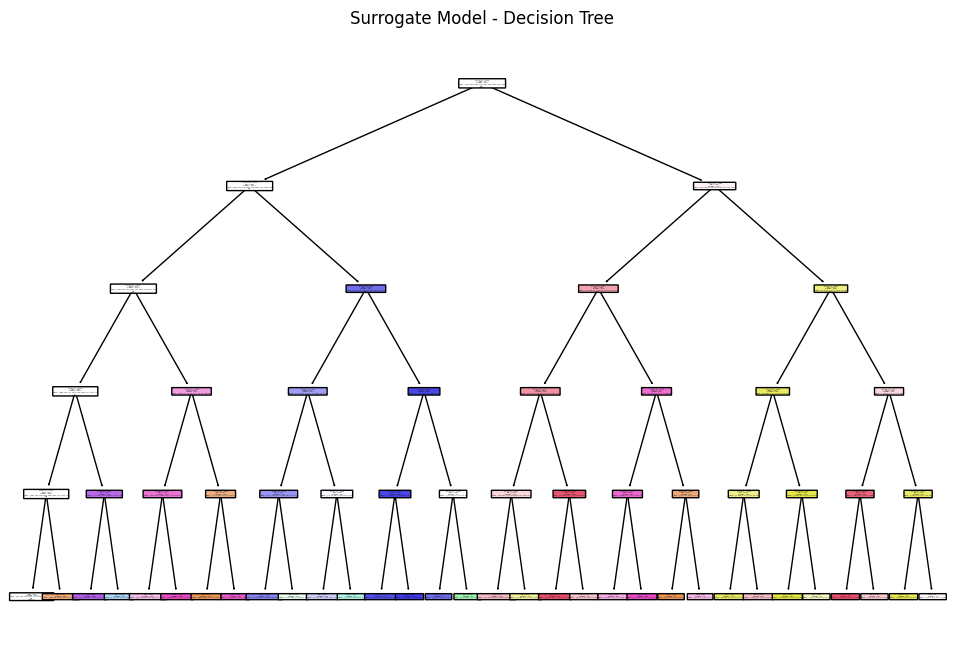

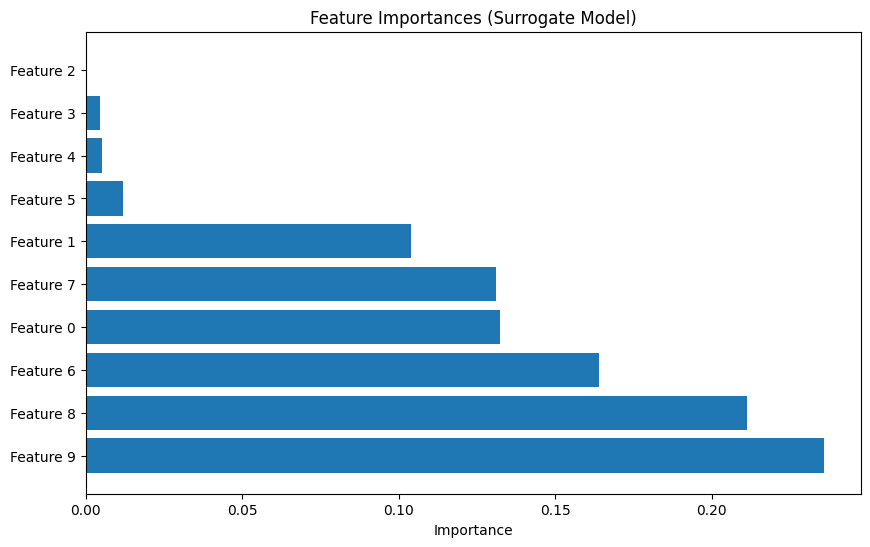

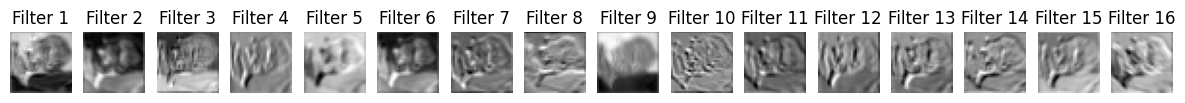

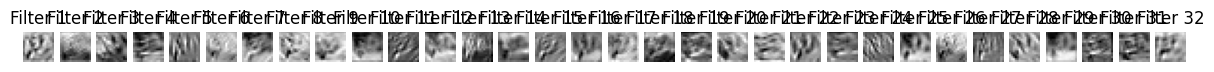

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

# 1. Load the Dataset (CIFAR-10)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

# 2. Define a Simple CNN Model for CIFAR-10
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)  # Input channels = 3 for RGB
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 8 * 8, 128)  # Changed to match CIFAR-10 size
        self.fc2 = nn.Linear(128, 10)  # 10 classes for CIFAR-10

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 32 * 8 * 8)  # Changed to match CIFAR-10 shape
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize the Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 3. Train the CNN Model
def train(model, trainloader, criterion, optimizer, epochs=3):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)  # CNN outputs (logits)

            # Print CNN output (logits) for the first image in the batch
            #print(f"Logits for first image in batch: {outputs[0]}")  # First image in the batch

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch + 1}, Loss: {running_loss / len(trainloader):.4f}")

train(model, trainloader, criterion, optimizer)

# 4. Extract Features for Surrogate Model
def extract_features(model, dataloader):
    model.eval()
    features, labels = [], []
    with torch.no_grad():
        for images, lbls in dataloader:
            images = images.to(device)
            outputs = model(images)  # CNN outputs (logits)

            # Print CNN outputs (logits) for the first image in each batch
            #print(f"Logits for first image in batch: {outputs[0]}")

            features.extend(outputs.cpu().numpy())  # Extract CNN outputs as features
            labels.extend(lbls.numpy())
    return np.array(features), np.array(labels)

X_train, y_train = extract_features(model, trainloader)
X_test, y_test = extract_features(model, testloader)

# 5. Train a Decision Tree Surrogate Model
dt = DecisionTreeClassifier(max_depth=5)  # Decision Tree model
dt.fit(X_train, y_train)

# Evaluate Surrogate Model
acc = dt.score(X_test, y_test)
print(f"Surrogate Model Accuracy: {acc * 100:.2f}%")

# 6. Visualize the Decision Tree (Surrogate Model)
def visualize_surrogate_model(dt):
    plt.figure(figsize=(12, 8))
    plot_tree(dt, filled=True, feature_names=[f"Feature {i}" for i in range(X_train.shape[1])], class_names=[str(i) for i in range(10)], rounded=True)
    plt.title("Surrogate Model - Decision Tree")
    plt.show()

visualize_surrogate_model(dt)

# 7. Visualize Feature Importance of the Surrogate Model
def plot_feature_importance(dt, feature_names):
    feature_importances = dt.feature_importances_
    indices = np.argsort(feature_importances)[::-1]

    plt.figure(figsize=(10, 6))
    plt.title("Feature Importances (Surrogate Model)")
    plt.barh(range(X_train.shape[1]), feature_importances[indices], align="center")
    plt.yticks(range(X_train.shape[1]), [f"Feature {i}" for i in indices])
    plt.xlabel("Importance")
    plt.show()

# Visualizing Feature Importance of the Surrogate Model
plot_feature_importance(dt, [f"Feature {i}" for i in range(X_train.shape[1])])

# --- Visualizing Feature Maps from the CNN --- #
def visualize_feature_maps(model, input_image):
    model.eval()
    layers = [model.conv1, model.conv2]  # Choose the convolutional layers to visualize
    activations = []

    def save_activation(name):
        def hook(model, input, output):
            activations.append(output)
        return hook

    # Register hooks to the convolutional layers
    hooks = []
    for layer in layers:
        hooks.append(layer.register_forward_hook(save_activation(layer.__class__.__name__)))

    # Perform a forward pass
    input_image = input_image.unsqueeze(0).to(device)
    model(input_image)

    # Visualize the feature maps
    for i, activation in enumerate(activations):
        activation = activation.squeeze(0).cpu().detach().numpy()
        num_filters = activation.shape[0]

        # Display the feature maps for each filter
        fig, axes = plt.subplots(1, num_filters, figsize=(15, 8))
        for j in range(num_filters):
            axes[j].imshow(activation[j], cmap='gray')
            axes[j].axis('off')
            axes[j].set_title(f"Filter {j + 1}")
        plt.show()

    # Remove hooks after visualization
    for hook in hooks:
        hook.remove()

# Visualize feature maps of a sample image from the test set
sample_image, sample_label = testset[0]
visualize_feature_maps(model, sample_image)